# TensorFlow Tutorial #18
# TFRecords & Dataset API

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

In the previous tutorials we used a so-called feed-dict for inputting data to the TensorFlow graph. It is a fairly simple input method but it is also a performance bottleneck because the data is read sequentially between training steps. This makes it hard to use the GPU at 100% efficiency because the GPU has to wait for new data to work on.

Instead we want to read data in a parallel thread so new training data is always available whenever the GPU is ready. This used to be done with so-called QueueRunners in TensorFlow which was a very complicated system. Now it can be done with the Dataset API and a binary file-format called TFRecords, as described in this tutorial.

This builds on Tutorial #17 for the Estimator API.

## Imports

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import numpy as np
import sys
import os

This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [68]:
tf.__version__

'1.13.1'

## Load Data

In [69]:
import mitero

The data dimensions have already been defined in the `mitero` module, so we just need to import the ones we need.

In [70]:
from mitero import img_size, img_size_flat, img_shape, num_classes, num_channels

Now load the data-set. This scans the sub-directories for all `*.jpg` images and puts the filenames into two lists for the training-set and test-set. This does not actually load the images.

In [71]:
dataset = mitero.load()

Creating dataset from the files in: data/Mitero_Images/
- Data saved to cache-file: data/Mitero_Images/mitero-images.pkl


Get the class-names.

In [72]:
class_names = dataset.class_names
#class_names

### Training and Test-Sets

This function returns the file-paths for the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In this tutorial we will actually use the integer class-numbers and call them labels. This may be a little confusing but you can always add print-statements to see what the data actually is.

In [73]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()

Print the first image-path to see if it looks OK.

In [74]:
image_paths_train[0]

'/home/rutherford/Github/Audilab_Project/11.Tree_Species_Indetification/data/Mitero_Images/Erica_arborea/images - 180.jpeg'

Get the test-set.

In [75]:
image_paths_test, cls_test, labels_test = dataset.get_test_set()

Print the first image-path to see if it looks OK.

In [76]:
image_paths_test[0]

'/home/rutherford/Github/Audilab_Project/11.Tree_Species_Indetification/data/Mitero_Images/Erica_arborea/test/images - 102.jpeg'

Get the validation-set

In [77]:
import mitero
from dataset import DataSet
#image_paths_validation, cls_train, labels_validation = dataset.get_validation_set()

In [78]:
#image_paths_validation, cls_test, labels_validation = dataset.get_validation_set()

The Mitero data-set has now been loaded and consists of 42334 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [79]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(image_paths_train)))
print("- Test-set:\t\t{}".format(len(image_paths_test)))
print("- Validation-set:\t\t{}".format(len(image_paths_test)))

Size of:
- Training-set:		42333
- Test-set:		5159
- Validation-set:		5159


### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [80]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name,
                                                       cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for loading images

This dataset does not load the actual images, instead it has a list of the images in the training-set and another list for the images in the test-set. This helper-function loads some image-files.

In [81]:
def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Plot a few images to see if data is correct

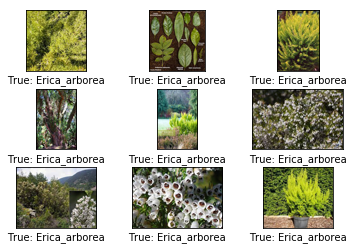

In [82]:
# Load the first images from the test-set.
images = load_images(image_paths=image_paths_test[0:9])

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

## Create TFRecords

TFRecords is the binary file-format used internally in TensorFlow which allows for high-performance reading and processing of datasets.

For this small dataset we will just create one TFRecords file for the training-set and another for the test-set. But if your dataset is very large then you can split it into several TFRecords files called shards. This will also improve the random shuffling, because the Dataset API only shuffles from a smaller buffer of e.g. 1024 elements loaded into RAM. So if you have e.g. 100 TFRecords files, then the randomization will be much better than for a single TFRecords file.

File-path for the TFRecords file holding the training-set.

In [57]:
path_tfrecords_train = os.path.join(mitero.data_dir, "train.tfrecords")
path_tfrecords_train

'data/Mitero_Images/train.tfrecords'

File-path for the TFRecords file holding the test-set.

In [83]:
path_tfrecords_test = os.path.join(mitero.data_dir, "validation.tfrecords")
path_tfrecords_test

'data/Mitero_Images/validation.tfrecords'

Helper-function for printing the conversion progress.

In [84]:
def print_progress(count, total):
    # Percentage completion.
    pct_complete = float(count) / total

    # Status-message.
    # Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

Helper-function for wrapping an integer so it can be saved to the TFRecords file.

In [85]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

Helper-function for wrapping raw bytes so they can be saved to the TFRecords file.

In [86]:
def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

This is the function for reading images from disk and writing them along with the class-labels to a TFRecords file. This loads and decodes the images to numpy-arrays and then stores the raw bytes in the TFRecords file. If the original image-files are compressed e.g. as jpeg-files, then the TFRecords file may be many times larger than the original image-files.

It is also possible to save the compressed image files directly in the TFRecords file because it can hold any raw bytes. We would then have to decode the compressed images when the TFRecords file is being read later in the `parse()` function below.

In [87]:
def convert(image_paths, labels, out_path):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.
    
    print("Converting: " + out_path)
    
    # Number of images. Used when printing the progress.
    num_images = len(image_paths)
    
    # Open a TFRecordWriter for the output-file.
    with tf.python_io.TFRecordWriter(out_path) as writer:
        
        # Iterate over all the image-paths and class-labels.
        for i, (path, label) in enumerate(zip(image_paths, labels)):
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)

            # Load the image-file using matplotlib's imread function.
            img = imread(path)
            
            # Convert the image to raw bytes.
            img_bytes = img.tostring()

            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64(label)
                }

            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)

            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)

            # Serialize the data.
            serialized = example.SerializeToString()
            
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)

Note the 4 function calls required to write the data-dict to the TFRecords file. In the original code-example from the Google Developers, these 4 function calls were actually nested. The design-philosophy for TensorFlow generally seems to be: If one function call is good, then 4 function calls are 4 times as good, and if they are nested then it is exponential goodness!

Of course, this is quite poor API design because the last function `writer.write()` should just be able to take the data-dict directly and then call the 3 other functions internally.

Convert the training-set to a TFRecords-file. Note how we use the integer class-numbers as the labels instead of the One-Hot encoded arrays.

In [ ]:

convert(image_paths=image_paths_train,
        labels=cls_train,
        out_path=path_tfrecords_train)

Convert the test-set to a TFRecords-file:

In [88]:

convert(image_paths=image_paths_test,
        labels=cls_test,
        out_path=path_tfrecords_test)


Converting: data/Mitero_Images/validation.tfrecords
- Progress: 100.0%

## Input Functions for the Estimator

The TFRecords files contain the data in a serialized binary format which needs to be converted back to images and labels of the correct data-type. We use a helper-function for this parsing:

In [45]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.decode_raw(image_raw, tf.uint8)
    
    # The type is now uint8 but we need it to be float.
    image = tf.cast(image, tf.float32)

    # Get the label associated with the image.
    label = parsed_example['label']

    # The image and label are now correct TensorFlow types.
    return image, label

Helper-function for creating an input-function that reads from TFRecords files for use with the Estimator API.

In [28]:
def input_fn(filenames, train, batch_size=32, buffer_size=2048):
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)

    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    dataset = dataset.batch(batch_size)

    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch

    return x, y

This is the input-function for the training-set for use with the Estimator API:

In [29]:
def train_input_fn():
    return input_fn(filenames=path_tfrecords_train, train=True)

This is the input-function for the test-set for use with the Estimator API:

In [30]:
def test_input_fn():
    return input_fn(filenames=path_tfrecords_test, train=False)

In [31]:
train_input_fn

<function __main__.train_input_fn()>

In [32]:
input_fn

<function __main__.input_fn(filenames, train, batch_size=32, buffer_size=2048)>

## Bayesian CNN

In [37]:
# define placeholders
x = tf.placeholder(tf.float32, shape=[None, 200*200])
y_true = tf.placeholder(tf.float32, shape=[None, 143])
# define variables: weights and bias
W = tf.Variable(tf.zeros([200*200, 143]))
b = tf.Variable(tf.zeros([143]))
# create graph operations
y = tf.matmul(x,W)+b
# define loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y))
# define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)
train=optimizer.minimize(cross_entropy)
# create session
epochs = 50
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for step in range(epochs):
        batch_x, batch_y = train.input_fn(32)
        sess.run(train, feed_dict={x:batch_x, y_true:batch_y})
    
    #EVALUATION
    correct_preds = tf.equal(tf.argmax(y,1), tf.argmax(y_true, 1))
    acc = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    
    print('Accuracy on test set: {}'.format(
        sess.run(acc, feed_dict={x: mnist_onehot.test.images, y_true: mnist_onehot.test.labels})))

AttributeError: 'Operation' object has no attribute 'input_fn'

### Input Function for Predicting on New Images

An input-function is also needed for predicting the class of new data. As an example we just use a few images from the test-set.

You could load any images you want here. Make sure they are the same dimensions as expected by the TensorFlow model, otherwise you need to resize the images.

In [29]:
some_images = load_images(image_paths=image_paths_test[0:9])

These images are now stored as numpy arrays in memory, so we can use the standard input-function for the Estimator API. Note that the images are loaded as uint8 data but it must be input to the TensorFlow graph as floats so we do a type-cast.

In [30]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'image': some_images.astype(np.float32)},
    num_epochs=1,
    shuffle=False)

ValueError: setting an array element with a sequence.

The class-numbers are actually not used in the input-function as it is not needed for prediction. However, the true class-number is needed when we plot the images further below.

In [31]:
some_images_cls = cls_test[0:9]

## Pre-Made / Canned Estimator

When using a pre-made Estimator, we need to specify the input features for the data. In this case we want to input images from our data-set which are numeric arrays of the given shape.

In [32]:
feature_image = tf.feature_column.numeric_column("image",
                                                 shape=img_shape)

You can have several input features which would then be combined in a list:

In [33]:
feature_columns = [feature_image]

In this example we want to use a 3-layer DNN with 512, 256 and 128 units respectively.

In [34]:
num_hidden_units = [512, 256, 128]

The `DNNClassifier` then constructs the neural network for us. We can also specify the activation function and various other parameters (see the docs). Here we just specify the number of classes and the directory where the checkpoints will be saved.

In [35]:
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                   hidden_units=num_hidden_units,
                                   activation_fn=tf.nn.relu,
                                   n_classes=num_classes,
                                   model_dir="./checkpoints_tutorial18-1/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoints_tutorial18-1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fad90272cf8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training

We can now train the model for a given number of iterations. This automatically loads and saves checkpoints so we can continue the training later.

In [36]:
model.train(input_fn=train_input_fn, steps=200)

Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-1/model.ckpt-0
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./checkpoints_tutorial18-1/model.ckpt.


ResourceExhaustedError: checkpoints_tutorial18-1/model.ckpt-0_temp_1c4876b69f24470285c3b987f9a79e53/part-00001-of-00002.data-00000-of-00001.tempstate8286811043424030514; No space left on device
	 [[node save/SaveV2_1 (defined at /home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py:1403) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'save/SaveV2_1', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-116e601eb599>", line 1, in <module>
    model.train(input_fn=train_input_fn, steps=200)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 358, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1124, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1158, in _train_model_default
    saving_listeners)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1403, in _train_with_estimator_spec
    log_step_count_steps=log_step_count_steps) as mon_sess:
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 508, in MonitoredTrainingSession
    stop_grace_period_secs=stop_grace_period_secs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 934, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 648, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1122, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1127, in _create_session
    return self._sess_creator.create_session()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 805, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 562, in create_session
    self._scaffold.finalize()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 219, in finalize
    self._saver.build()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 844, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 881, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 504, in _build_internal
    save_tensor = self._AddShardedSaveOps(filename_tensor, per_device)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 295, in _AddShardedSaveOps
    return self._AddShardedSaveOpsForV2(filename_tensor, per_device)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 269, in _AddShardedSaveOpsForV2
    sharded_saves.append(self._AddSaveOps(sharded_filename, saveables))
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 210, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 124, in save_op
    tensors)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1807, in save_v2
    name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): checkpoints_tutorial18-1/model.ckpt-0_temp_1c4876b69f24470285c3b987f9a79e53/part-00001-of-00002.data-00000-of-00001.tempstate8286811043424030514; No space left on device
	 [[node save/SaveV2_1 (defined at /home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py:1403) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



### Evaluation

Once the model has been trained, we can evaluate its performance on the test-set.

In [37]:
result = model.evaluate(input_fn=test_input_fn)

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-20T10:40:23Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-1/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [150930], [batch]: [151875]
	 [[node IteratorGetNext (defined at <ipython-input-26-9983b1ac2903>:40) ]]

Caused by op 'IteratorGetNext', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-b6db7181bf2d>", line 1, in <module>
    result = model.evaluate(input_fn=test_input_fn)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 469, in evaluate
    name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 511, in _actual_eval
    return _evaluate()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 493, in _evaluate
    self._evaluate_build_graph(input_fn, hooks, checkpoint_path))
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1424, in _evaluate_build_graph
    self._call_model_fn_eval(input_fn, self.config))
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1457, in _call_model_fn_eval
    input_fn, model_fn_lib.ModeKeys.EVAL)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 992, in _get_features_and_labels_from_input_fn
    self._call_input_fn(input_fn, mode))
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1079, in _call_input_fn
    return input_fn(**kwargs)
  File "<ipython-input-28-7849c2f8c5fa>", line 2, in test_input_fn
    return input_fn(filenames=path_tfrecords_test, train=False)
  File "<ipython-input-26-9983b1ac2903>", line 40, in input_fn
    images_batch, labels_batch = iterator.get_next()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1685, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [150930], [batch]: [151875]
	 [[node IteratorGetNext (defined at <ipython-input-26-9983b1ac2903>:40) ]]


In [57]:
result

NameError: name 'result' is not defined

In [58]:
print("Classification accuracy: {0:.2%}".format(result["accuracy"]))

NameError: name 'result' is not defined

### Predictions

The trained model can also be used to make predictions on new data.

Note that the TensorFlow graph is recreated and the checkpoint is reloaded every time we make predictions on new data. If the model is very large then this could add a significant overhead.

It is unclear why the Estimator is designed this way, possibly because it will always use the latest checkpoint and it can also be distributed easily for use on multiple computers.

In [59]:
predictions = model.predict(input_fn=predict_input_fn)

NameError: name 'predict_input_fn' is not defined

In [60]:
cls = [p['classes'] for p in predictions]

NameError: name 'predictions' is not defined

In [61]:
cls_pred = np.array(cls, dtype='int').squeeze()
cls_pred

NameError: name 'cls' is not defined

In [62]:
plot_images(images=some_images,
            cls_true=some_images_cls,
            cls_pred=cls_pred)

NameError: name 'cls_pred' is not defined

### Predictions for the Entire Test-Set

It appears that the model maybe classifies all images as 'spoony'. So let us see the predictions for the entire test-set. We can do this simply by using its input-function:

In [63]:
predictions = model.predict(input_fn=test_input_fn)

In [64]:
cls = [p['classes'] for p in predictions]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-1/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [150930], [batch]: [151875]
	 [[node IteratorGetNext (defined at <ipython-input-45-9983b1ac2903>:40) ]]

Caused by op 'IteratorGetNext', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-64-e1ce55a32c73>", line 1, in <module>
    cls = [p['classes'] for p in predictions]
  File "<ipython-input-64-e1ce55a32c73>", line 1, in <listcomp>
    cls = [p['classes'] for p in predictions]
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 609, in predict
    input_fn, model_fn_lib.ModeKeys.PREDICT)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 967, in _get_features_from_input_fn
    result = self._call_input_fn(input_fn, mode)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1079, in _call_input_fn
    return input_fn(**kwargs)
  File "<ipython-input-47-7849c2f8c5fa>", line 2, in test_input_fn
    return input_fn(filenames=path_tfrecords_test, train=False)
  File "<ipython-input-45-9983b1ac2903>", line 40, in input_fn
    images_batch, labels_batch = iterator.get_next()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1685, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [150930], [batch]: [151875]
	 [[node IteratorGetNext (defined at <ipython-input-45-9983b1ac2903>:40) ]]


In [65]:
cls_pred = np.array(cls, dtype='int').squeeze()

NameError: name 'cls' is not defined

The test-set contains 530 images in total and they have all been predicted as class 2 (spoony). So this model does not work at all for classifying the Knifey-Spoony dataset.

In [66]:
np.sum(cls_pred == 2)

NameError: name 'cls_pred' is not defined

# New Estimator

If you cannot use one of the built-in Estimators, then you can create an arbitrary TensorFlow model yourself. To do this, you first need to create a function which defines the following:

1. The TensorFlow model, e.g. a Convolutional Neural Network.
2. The output of the model.
3. The loss-function used to improve the model during optimization.
4. The optimization method.
5. Performance metrics.

The Estimator can be run in three modes: Training, Evaluation, or Prediction. The code is mostly the same, but in Prediction-mode we do not need to setup the loss-function and optimizer.

This is another aspect of the Estimator API that is poorly designed and resembles how we did ANSI C programming using structs in the old days. It would probably have been more elegant to split this into several functions and sub-classed the Estimator-class.

In [67]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
    # Reference to the tensor named "image" in the input-function.
    x = features["image"]

    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    net = tf.reshape(x, [-1, img_size, img_size, num_channels])    

    # First convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=32, kernel_size=3,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

    # Second convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv2',
                           filters=32, kernel_size=3,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)    

    # Flatten to a 2-rank tensor.
    net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    # net = tf.layers.flatten(net)

    # First fully-connected / dense layer.
    # This uses the ReLU activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc1',
                          units=128, activation=tf.nn.relu)    

    # Second fully-connected / dense layer.
    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc_2',
                          units=num_classes)

    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1)

    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred_cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        loss = tf.reduce_mean(cross_entropy)

        # Define the optimizer for improving the neural network.
        optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])

        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())

        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls)
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
    return spec

### Create an Instance of the Estimator

We can specify hyper-parameters e.g. for the learning-rate of the optimizer.

In [68]:
params = {"learning_rate": 1e-4}

We can then create an instance of the new Estimator.

Note that we don't provide feature-columns here as it is inferred automatically from the data-functions when `model_fn()` is called.

It is unclear from the TensorFlow documentation why it is necessary to specify the feature-columns when using `DNNClassifier` in the example above, when it is not needed here.

In [69]:
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir="./checkpoints_tutorial18-2/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoints_tutorial18-2/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f837e476be0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training

Now that our new Estimator has been created, we can train it.

In [70]:
model.train(input_fn=train_input_fn, steps=200)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./checkpoints_tutorial18-2/model.ckpt.


InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [151008] and element 1 had shape [151515].
	 [[node IteratorGetNext (defined at <ipython-input-45-9983b1ac2903>:40) ]]

Caused by op 'IteratorGetNext', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-70-116e601eb599>", line 1, in <module>
    model.train(input_fn=train_input_fn, steps=200)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 358, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1124, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1151, in _train_model_default
    input_fn, model_fn_lib.ModeKeys.TRAIN))
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 992, in _get_features_and_labels_from_input_fn
    self._call_input_fn(input_fn, mode))
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1079, in _call_input_fn
    return input_fn(**kwargs)
  File "<ipython-input-46-244cb15da1cc>", line 2, in train_input_fn
    return input_fn(filenames=path_tfrecords_train, train=True)
  File "<ipython-input-45-9983b1ac2903>", line 40, in input_fn
    images_batch, labels_batch = iterator.get_next()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1685, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot batch tensors with different shapes in component 0. First element had shape [151008] and element 1 had shape [151515].
	 [[node IteratorGetNext (defined at <ipython-input-45-9983b1ac2903>:40) ]]


### Evaluation

Once the model has been trained, we can evaluate its performance on the test-set.

In [71]:
result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-14T15:57:26Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-2/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [150930], [batch]: [151875]
	 [[node IteratorGetNext (defined at <ipython-input-45-9983b1ac2903>:40) ]]

Caused by op 'IteratorGetNext', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-b6db7181bf2d>", line 1, in <module>
    result = model.evaluate(input_fn=test_input_fn)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 469, in evaluate
    name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 511, in _actual_eval
    return _evaluate()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 493, in _evaluate
    self._evaluate_build_graph(input_fn, hooks, checkpoint_path))
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1424, in _evaluate_build_graph
    self._call_model_fn_eval(input_fn, self.config))
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1457, in _call_model_fn_eval
    input_fn, model_fn_lib.ModeKeys.EVAL)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 992, in _get_features_and_labels_from_input_fn
    self._call_input_fn(input_fn, mode))
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1079, in _call_input_fn
    return input_fn(**kwargs)
  File "<ipython-input-47-7849c2f8c5fa>", line 2, in test_input_fn
    return input_fn(filenames=path_tfrecords_test, train=False)
  File "<ipython-input-45-9983b1ac2903>", line 40, in input_fn
    images_batch, labels_batch = iterator.get_next()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1685, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [150930], [batch]: [151875]
	 [[node IteratorGetNext (defined at <ipython-input-45-9983b1ac2903>:40) ]]


In [72]:
result

NameError: name 'result' is not defined

In [73]:
print("Classification accuracy: {0:.2%}".format(result["accuracy"]))

NameError: name 'result' is not defined

### Predictions

The model can also be used to make predictions on new data.

In [74]:
predictions = model.predict(input_fn=predict_input_fn)

NameError: name 'predict_input_fn' is not defined

In [75]:
cls_pred = np.array(list(predictions))
cls_pred

array([], dtype=float64)

IndexError: index 0 is out of bounds for axis 0 with size 0

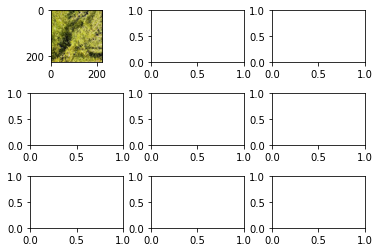

In [76]:
plot_images(images=some_images,
            cls_true=some_images_cls,
            cls_pred=cls_pred)

### Predictions for the Entire Test-Set

To get the predicted classes for the entire test-set, we just use its input-function:

In [77]:
predictions = model.predict(input_fn=test_input_fn)

In [78]:
cls_pred = np.array(list(predictions))
cls_pred

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-2/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [150930], [batch]: [151875]
	 [[node IteratorGetNext (defined at <ipython-input-45-9983b1ac2903>:40) ]]

Caused by op 'IteratorGetNext', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rutherford/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rutherford/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-cb5bc2c49e3d>", line 1, in <module>
    cls_pred = np.array(list(predictions))
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 609, in predict
    input_fn, model_fn_lib.ModeKeys.PREDICT)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 967, in _get_features_from_input_fn
    result = self._call_input_fn(input_fn, mode)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1079, in _call_input_fn
    return input_fn(**kwargs)
  File "<ipython-input-47-7849c2f8c5fa>", line 2, in test_input_fn
    return input_fn(filenames=path_tfrecords_test, train=False)
  File "<ipython-input-45-9983b1ac2903>", line 40, in input_fn
    images_batch, labels_batch = iterator.get_next()
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1685, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [150930], [batch]: [151875]
	 [[node IteratorGetNext (defined at <ipython-input-45-9983b1ac2903>:40) ]]


The Convolutional Neural Network predicts different classes for the images, although most have just been classified as 0 (forky), so the accuracy is horrible.

In [79]:
np.sum(cls_pred == 0)

0

In [80]:
np.sum(cls_pred == 1)

0

In [81]:
np.sum(cls_pred == 2)

0

## Conclusion

This tutorial showed how to use TensorFlow's binary file-format TFRecords with the Dataset and Estimator APIs. This should simplify the process of training models with very large datasets while getting high usage of the GPU. However, the API could have been simpler in many ways.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Train the Convolutional Neural Network for much longer. Does it get any better at classifying the Knifey-Spoony dataset?
* Save the One-Hot-encoded label instead of the class-integer in the TFRecord and modify the rest of the code to use it.
* Make shards so you save multiple TFRecord files instead of just one.
* Save jpeg-files in the TFRecord instead of the decoded image. You will then need to decode the jpeg-image in the `parse()` function. What are the pro's and con's of doing this?
* Try using another dataset.
* Use a dataset where the images are different sizes. Would you resize before or after converting to the TFRecords file? Why?
* Try and use numpy input-functions instead of TFRecords for the Estimator API. What is the performance difference?
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.